<a href="https://colab.research.google.com/github/sinclairfr/YOLOv5-on-SKU110K/blob/main/yolov5_training_on_sku110K.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# YOLOv5 on SKU110K dataset

## Include libraries

In [39]:
import glob
import os
import torch
from google.colab import runtime
from IPython.display import Image, display, clear_output
from google.colab import drive
from pathlib import Path


## Set up CUDA

In [40]:
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.0.0+cu118 (CPU)


## Prepare the SKU110K dataset

[SKU110K repository on GitHub](https://github.com/datasith/ds-datasets-sku110k).


In [41]:
#!wget -O /root/.kaggle/kaggle.json https://cloud.domainelibre.com/s/f72EdLJt69ySjEm/download
#!kaggle datasets download -d thedatasith/sku110k-annotations
#!unzip -e sku110k-annotations.zip
#DATASET_DIR = "/content/"

In [42]:
drive.mount('/content/drive')
DATASET_DIR = "/content/drive/MyDrive/notebooks/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
!ls "$DATASET_DIR"/SKU110K_fixed

data_kaggle.yaml  labels      medo_test		     my_yolov5_model
images		  labels.txt  metadata_writer_v1.py


## Train our custom YOLOv5 model

In [44]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

In [45]:
!pip install -r ./yolov5/requirements.txt > /dev/null 2>&1

In [46]:
YAML_PATH = Path(DATASET_DIR) / "SKU110K_fixed" 
YAML_FILE_PATH = YAML_PATH / "data_kaggle.yaml"
DATASET = "/content/drive/MyDrive/notebooks/SKU110K_fixed/"
CUSTOM_MODEL_PATH = Path(DATASET) / "my_yolov5_model/"

In [47]:
!cat "$YAML_FILE_PATH"

path: /content/drive/MyDrive/notebooks/SKU110K_fixed/images  # dataset root dir
train: train  # train images (relative to 'path')  8219 images
val: val  # val images (relative to 'path')  588 images
test: test  # test images (optional)  2936 images

# Classes
nc: 1  # number of classes
names: ['object']  # class names

The `train.py` script of `YOLOv5` allows us to pass a number of arguments:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs. (Note: often, 3000+ are common here!)
- **data:** our dataset location
- **weights:** specify a path to weights to start transfer learning from
- **cache:** cache images for faster training

In [48]:
# Set the path to the pre-trained weights file
weights_path = "$CUSTOM_MODEL_PATH/weights/best.pt"

# Set the number of epochs to train for
num_epochs = 1

command = "python ./yolov5/train.py --exist-ok --img 416 --batch 30 --epochs {0} --data {1} --weights {2} --project  $DATASET --name my_yolov5_model".format(num_epochs, YAML_FILE_PATH, weights_path)

# Run the training command as a shell command in the notebook environment
#!{command}

In [49]:
# Programmatically kill the notebook to save processing units
#runtime.unassign()

## Export to ONNX

ONNX (Open Neural Network Exchange) is an open-source format for representing machine learning models. It allows interoperability between different deep learning frameworks, making it easier to move models between different tools and platforms.

In [50]:
!python /content/yolov5/export.py --weights "$CUSTOM_MODEL_PATH/weights/best.pt" --include onnx --img 416 --data "$DATASET/data_kaggle.yaml"

export: data=/content/drive/MyDrive/notebooks/SKU110K_fixed//data_kaggle.yaml, weights=['/content/drive/MyDrive/notebooks/SKU110K_fixed/my_yolov5_model/weights/best.pt'], imgsz=[416], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['onnx']
YOLOv5 🚀 v7.0-158-g8211a03 Python-3.10.11 torch-2.0.0+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from /content/drive/MyDrive/notebooks/SKU110K_fixed/my_yolov5_model/weights/best.pt with output shape (1, 10647, 6) (13.6 MB)

ONNX: starting export with onnx 1.13.1...
============= Diagnostic Run torch.onnx.export version 2.0.0+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ===================

In [51]:
!pip install onnx-tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
!ls $CUSTOM_MODEL_PATH/weights

best.onnx  best.pt  epoch0.pt  last.pt


## Exporting to tflite

In [63]:
#!tflite_convert --saved_model_dir $CUSTOM_MODEL_PATH/weights/onnx_saved_model/ --output_file $CUSTOM_MODEL_PATH/weights/onnx_saved_model/best_model.tflite

In [64]:
!python /content/yolov5/export.py --weights $CUSTOM_MODEL_PATH/weights/best.pt --include tflite --int8 --img 416 --data "$DATASETdata_kaggle.yaml"

export: data=/content/drive/MyDrive/notebooks/SKU110K_fixed//data_kaggle.yaml, weights=['/content/drive/MyDrive/notebooks/SKU110K_fixed/my_yolov5_model/weights/best.pt'], imgsz=[416], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=True, dynamic=False, simplify=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['tflite']
YOLOv5 🚀 v7.0-158-g8211a03 Python-3.10.11 torch-2.0.0+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from /content/drive/MyDrive/notebooks/SKU110K_fixed/my_yolov5_model/weights/best.pt with output shape (1, 10647, 6) (13.6 MB)

TensorFlow SavedModel: starting export with tensorflow 2.12.0...

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv         

## Testing

In [58]:
IMG_PATH = YAML_PATH
IMG_FILE_PATH = IMG_PATH / "images/test"
IMG_FILE_PATH

PosixPath('/content/drive/MyDrive/notebooks/SKU110K_fixed/images/test')

In [85]:
#MODEL_PATH="$CUSTOM_MODEL_PATH/weights/best.pt"
#MODEL_PATH="$CUSTOM_MODEL_PATH/weights/onnx_saved_model/best_model.tflite"
#MODEL_PATH="$CUSTOM_MODEL_PATH/weights/best.onnx"
TEST_IMG_PATH= Path(DATASET) / "medo_test/il-faut-nettoyer-regulierement-son-frigo-pour-eviter-la-proliferation-de-bacteries-photo-d-illustration-flickr-jpc24m-1515879545.jpg"

epoch0.pt
detect: weights=['/content/drive/MyDrive/notebooks/SKU110K_fixed/my_yolov5_model/weights/epoch0.pt'], source=/content/drive/MyDrive/notebooks/SKU110K_fixed/medo_test/il-faut-nettoyer-regulierement-son-frigo-pour-eviter-la-proliferation-de-bacteries-photo-d-illustration-flickr-jpc24m-1515879545.jpg, data=yolov5/data/coco128.yaml, imgsz=[416, 416], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-158-g8211a03 Python-3.10.11 torch-2.0.0+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/drive/MyDrive/notebooks/SKU110K_fixed/medo_t

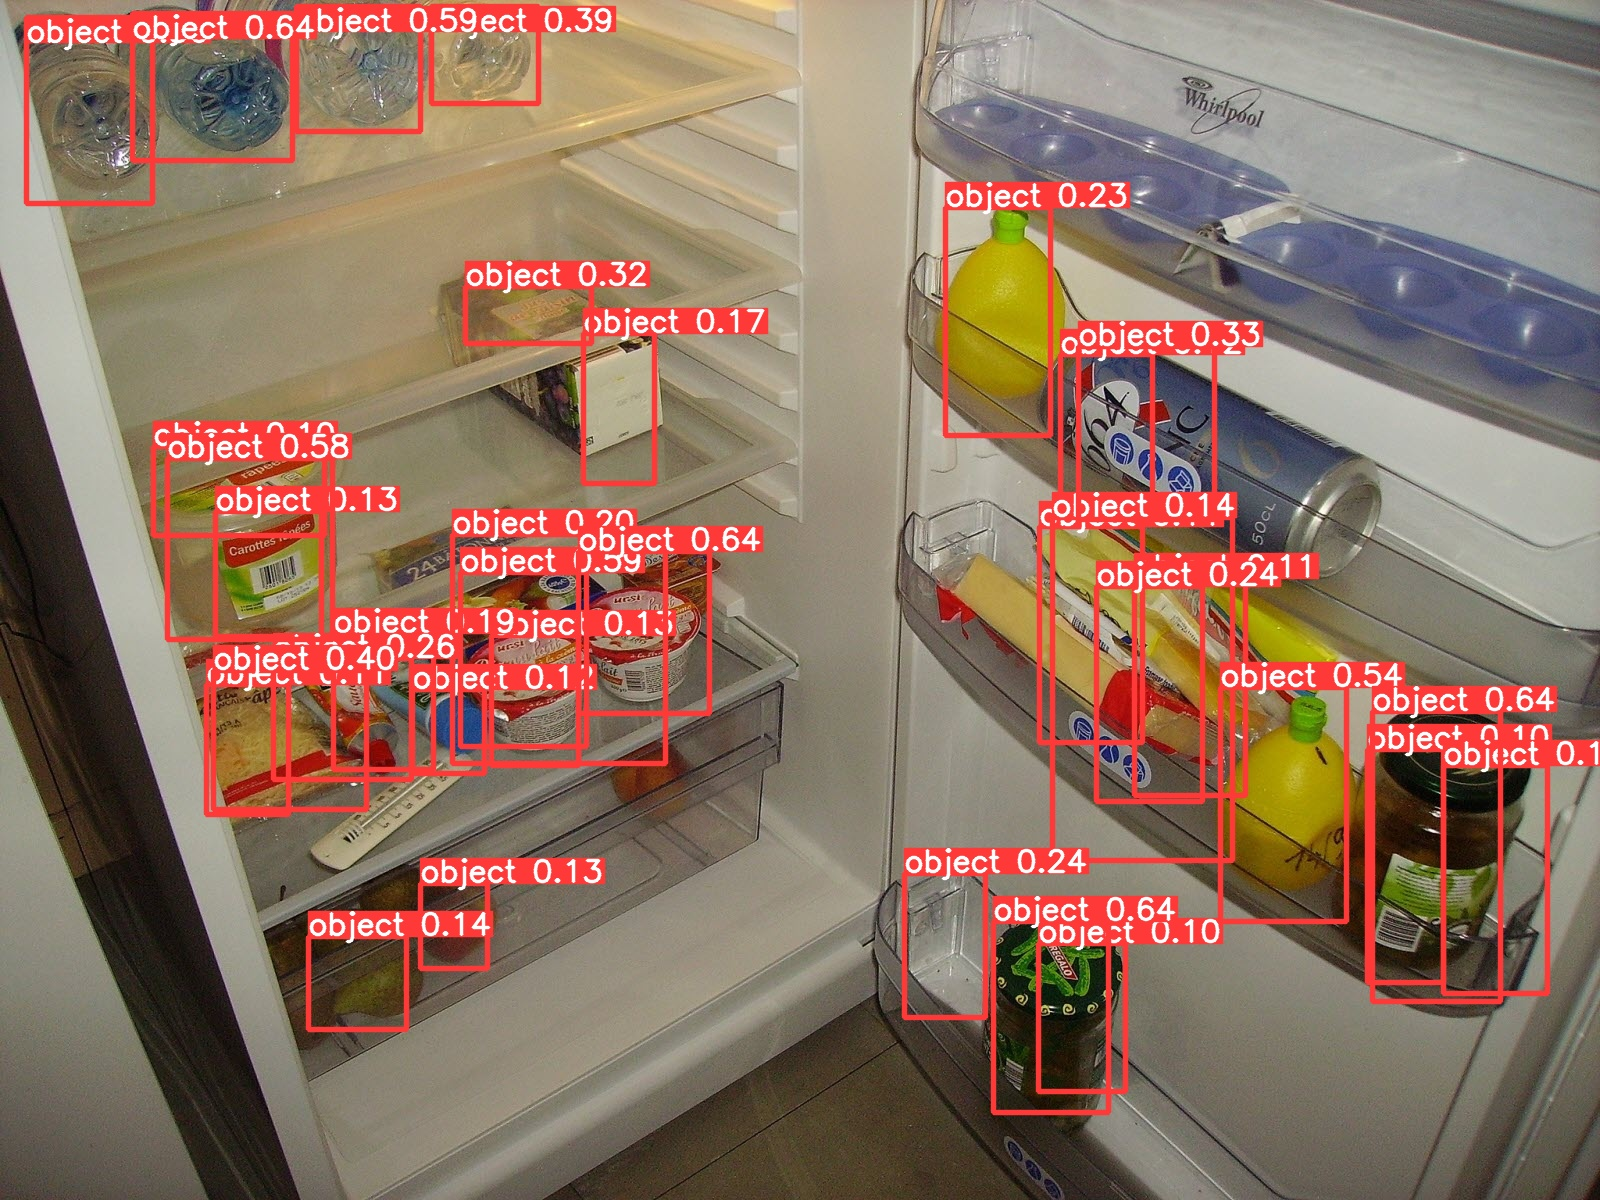

last.pt
detect: weights=['/content/drive/MyDrive/notebooks/SKU110K_fixed/my_yolov5_model/weights/last.pt'], source=/content/drive/MyDrive/notebooks/SKU110K_fixed/medo_test/il-faut-nettoyer-regulierement-son-frigo-pour-eviter-la-proliferation-de-bacteries-photo-d-illustration-flickr-jpc24m-1515879545.jpg, data=yolov5/data/coco128.yaml, imgsz=[416, 416], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-158-g8211a03 Python-3.10.11 torch-2.0.0+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/drive/MyDrive/notebooks/SKU110K_fixed/medo_test/

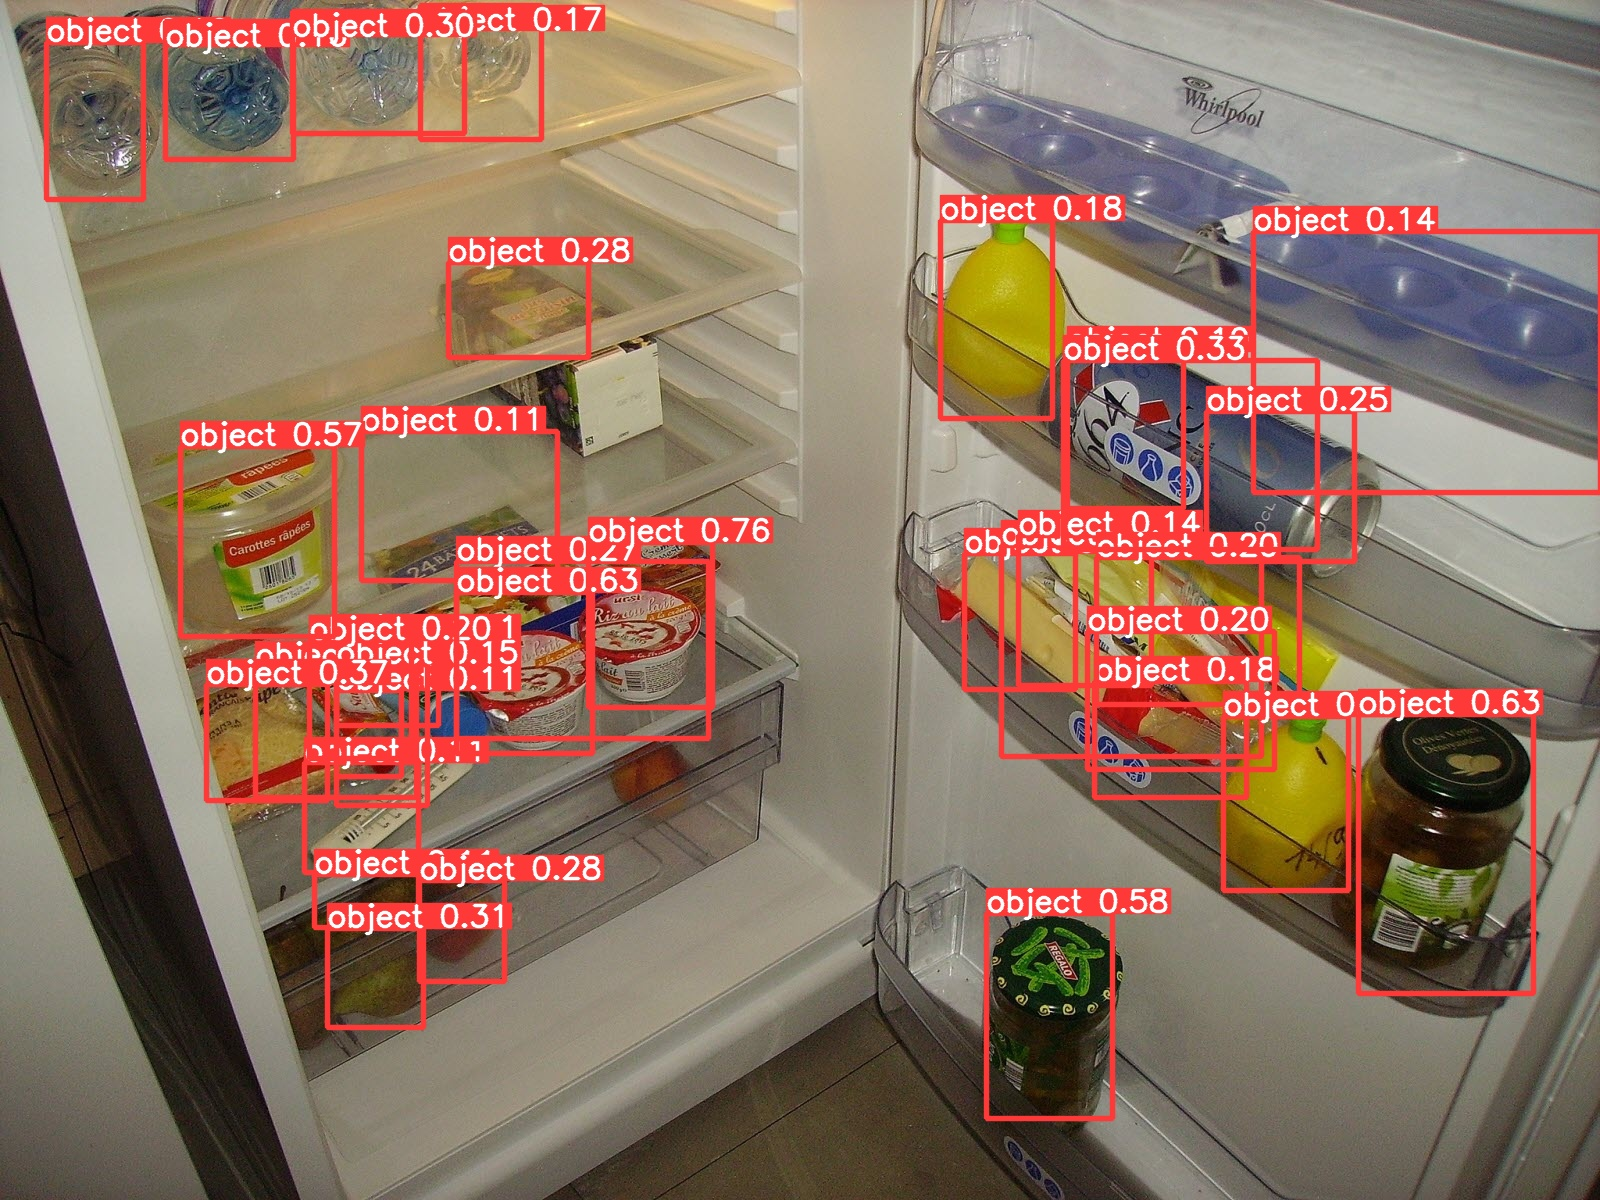

best.pt
detect: weights=['/content/drive/MyDrive/notebooks/SKU110K_fixed/my_yolov5_model/weights/best.pt'], source=/content/drive/MyDrive/notebooks/SKU110K_fixed/medo_test/il-faut-nettoyer-regulierement-son-frigo-pour-eviter-la-proliferation-de-bacteries-photo-d-illustration-flickr-jpc24m-1515879545.jpg, data=yolov5/data/coco128.yaml, imgsz=[416, 416], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-158-g8211a03 Python-3.10.11 torch-2.0.0+cu118 CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /content/drive/MyDrive/notebooks/SKU110K_fixed/medo_test/

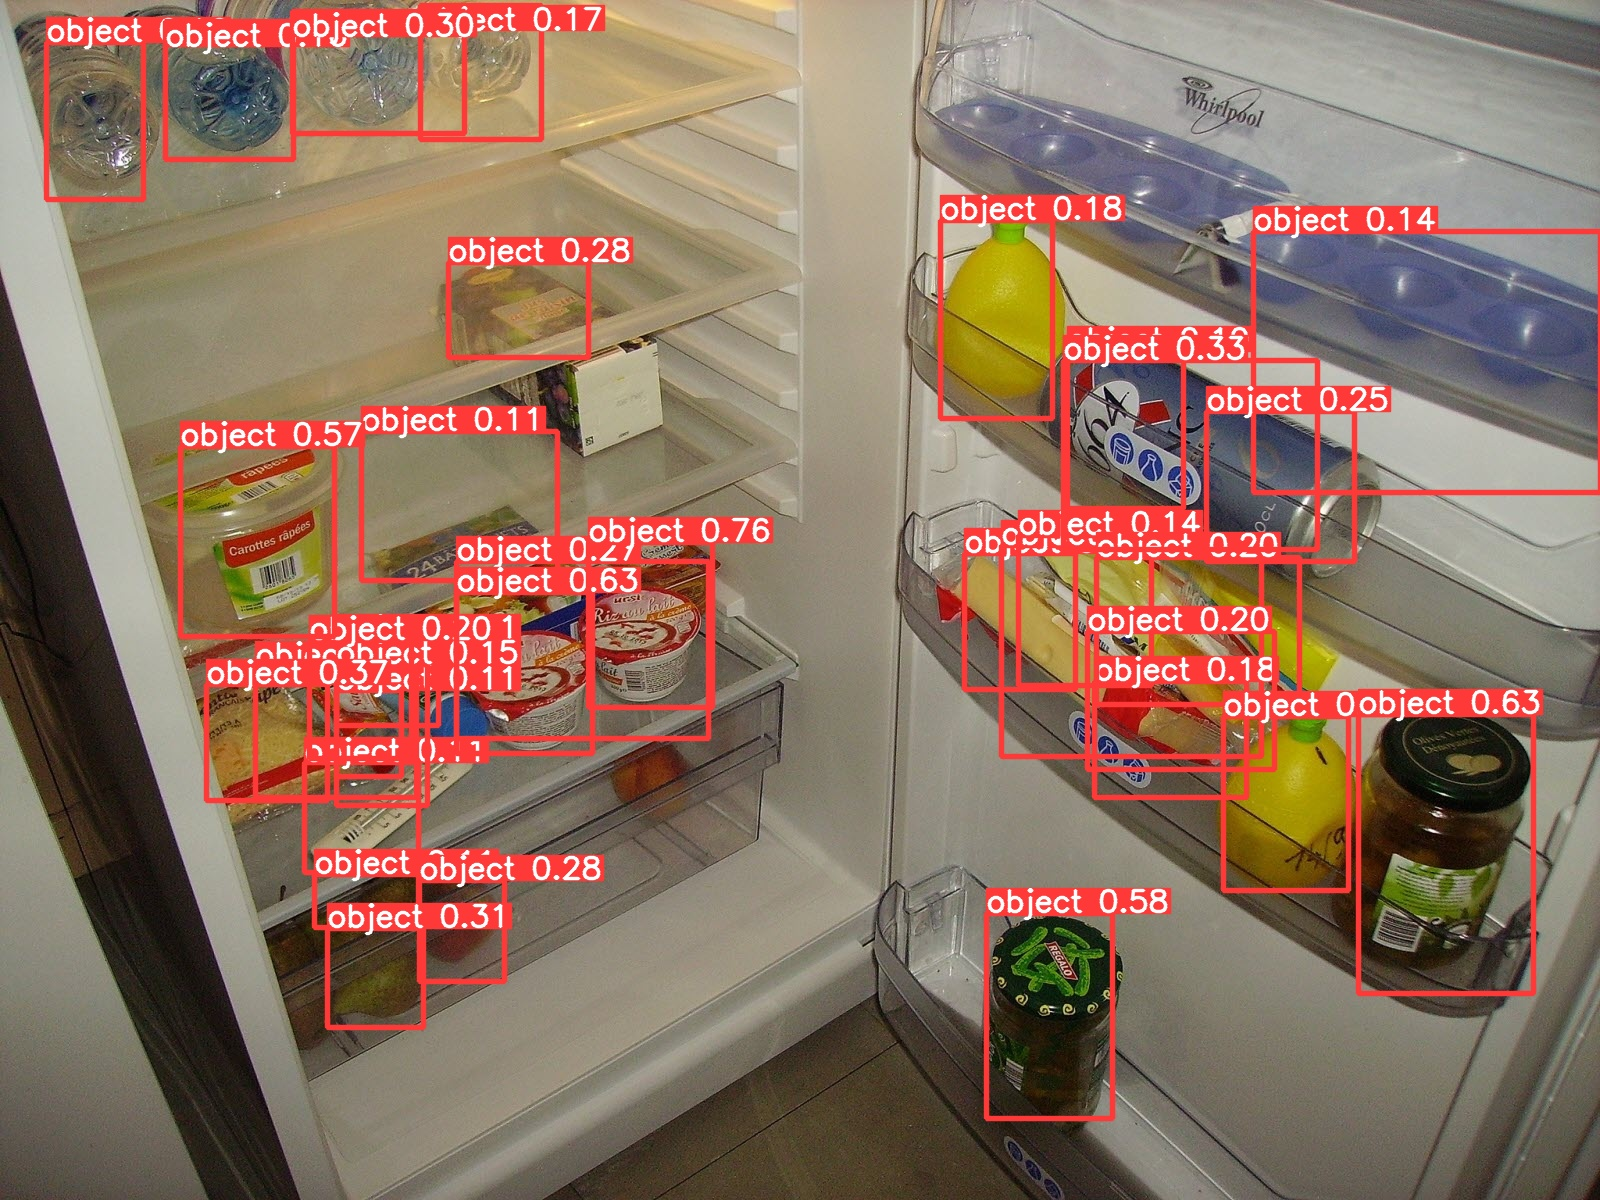

best-int8.tflite
detect: weights=['/content/drive/MyDrive/notebooks/SKU110K_fixed/my_yolov5_model/weights/best-int8.tflite'], source=/content/drive/MyDrive/notebooks/SKU110K_fixed/medo_test/il-faut-nettoyer-regulierement-son-frigo-pour-eviter-la-proliferation-de-bacteries-photo-d-illustration-flickr-jpc24m-1515879545.jpg, data=yolov5/data/coco128.yaml, imgsz=[416, 416], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /content/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-158-g8211a03 Python-3.10.11 torch-2.0.0+cu118 CPU

Loading /content/drive/MyDrive/notebooks/SKU110K_fixed/my_yolov5_model/weights/best-int8.tflite for TensorFlow Lite inference...
INFO: Crea

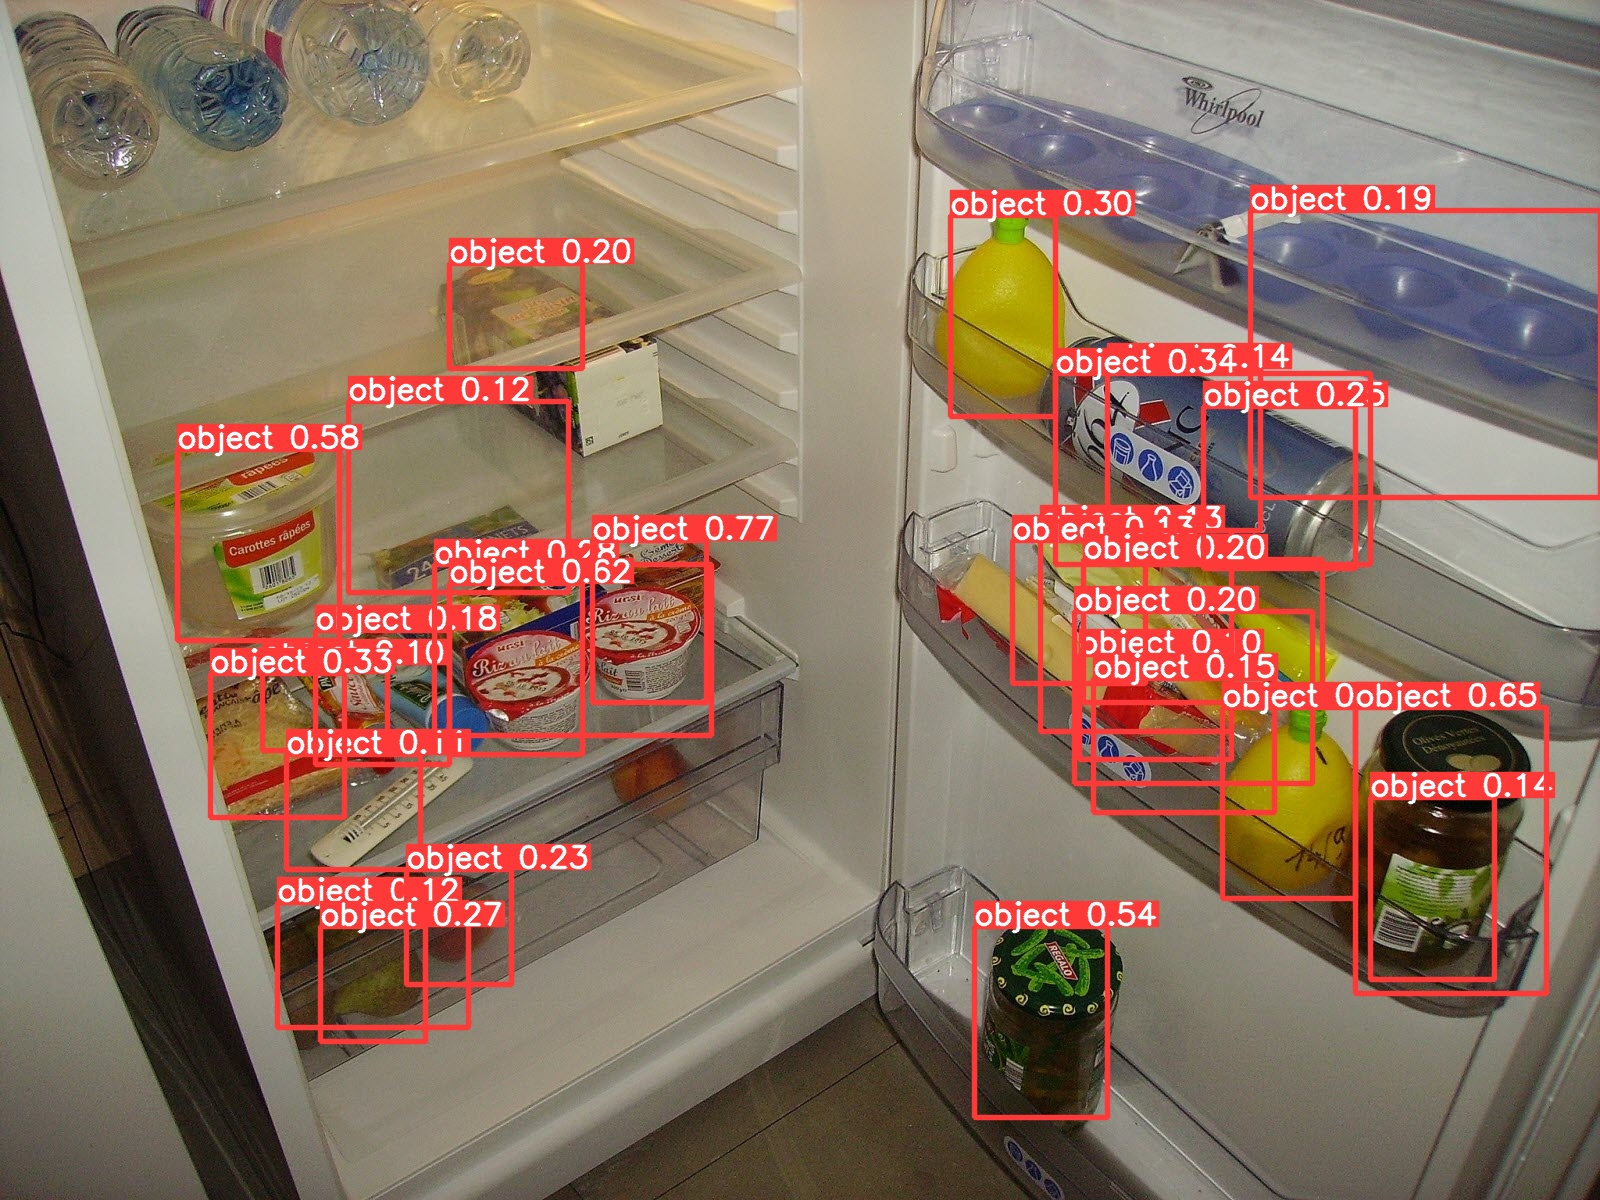

In [88]:
from torch.nn.modules import flatten
for filename in os.listdir(CUSTOM_MODEL_PATH/"weights"):
  if filename.endswith(".pt") or filename.endswith(".tflite"):
    print(filename)
    MODEL_PATH=CUSTOM_MODEL_PATH / "weights" / filename
    !python yolov5/detect.py --exist-ok --weights $MODEL_PATH --img 416 --conf-thres 0.1 --source $TEST_IMG_PATH
    display(Image(filename='yolov5/runs/detect/exp/il-faut-nettoyer-regulierement-son-frigo-pour-eviter-la-proliferation-de-bacteries-photo-d-illustration-flickr-jpc24m-1515879545.jpg', width=600))

## Batch testing


In [ ]:
!python yolov5/detect.py --exist-ok --weights $CUSTOM_MODEL_PATH/weights/best.pt --img 416 --conf-thres 0.1 --source "$IMG_FILE_PATH"

In [ ]:
#display inference on a random test image
import random
images = glob.glob('yolov5/runs/detect/exp/*.jpg') #assuming JPG
idx = random.randint(0,len(images))
imageName = images[idx]
display(Image(filename=imageName, width=600))